In [1]:
import os
root_dir = os.getcwd()

In [2]:
pip install -r requirements.txt

  Using cached tensorflow-2.9.1-cp37-cp37m-win_amd64.whl (444.0 MB)
  Using cached tensorboard-2.9.1-py3-none-any.whl (5.8 MB)
  Using cached tensorflow_estimator-2.9.0-py2.py3-none-any.whl (438 kB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 1.14.0
    Uninstalling tensorflow-estimator-1.14.0:
      Successfully uninstalled tensorflow-estimator-1.14.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 1.14.0
    Uninstalling tensorboard-1.14.0:
      Successfully uninstalled tensorboard-1.14.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0
Note: you may need to restart the kernel to use updated packages.


In [3]:
# -*- coding: utf-8 -*-
"""
Created on Sat Jun 4 13:47:35 2022

@author: mjvat
"""

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import requests
import zipfile
from io import BytesIO
import warnings
warnings.filterwarnings('ignore')

In [4]:
class ANN():
    
    def __init__(self, my_path=None, img_path=None, training_path=None, \
                 test_path=None, train_generator=None, test_generator=None, \
                 train_images=None, test_images=None, inputs=None, outputs=None, \
                 x=None, model=None, history=None, accuracy=None, preds=None, \
                 cm=None, clr=None, data=None, zipfile=None):
        
        self.my_path = os.getcwd()
        self.img_path = 'https://github.com/mjvatt/MS-Artificial-Intelligence-and-Machine-Learning/raw/main/image_data.zip'
        
        self.training_path = self.my_path + '/training_test_data/train/'
        self.test_path = self.my_path + '/training_test_data/test/'
        
        self.data = 'image_data'
        self.zipfile = zipfile
        
        self.train_generator = train_generator
        self.test_generator = test_generator
        
        self.train_images = train_images 
        self.test_images = test_images 
        
        self.inputs = inputs
        self.outputs = outputs
        
        self.x = x
        self.model = model
        self.history = history
        
        self.accuracy = accuracy
        self.preds = preds
        
        self.cm = cm
        self.clr = clr
    
    def get_data(self):
        
        # self.data = wget.download(self.img_path)
        print('Downloading started')
        # print(self.img_path)
         
        # Split URL to get the file name
        filename = self.img_path.split('/')[-1]
         
        # Downloading the file by sending the request to the URL
        req = requests.get(self.img_path)
        
        # Writing the file to the local file system
        with open(filename,'wb') as output_file:
            output_file.write(req.content)
        print('Downloading Completed')
        
        # extracting the zip file contents
        self.zipfile = zipfile.ZipFile(BytesIO(req.content))
        self.zipfile.extractall(self.my_path)    

    def splitFolders(self):
    
        splitfolders.ratio(self.data, output='training_test_data', \
                           seed=1337, ratio=(0.8, 0.0, 0.2))
            
    def trainGen(self):
        
        self.train_generator = ImageDataGenerator(
                                    rescale=1./255,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    rotation_range=90,
                                    height_shift_range=0.2,
                                    width_shift_range=0.2,
                                    zoom_range=0.2
                                )
        
    def testGen(self):
        
        self.test_generator = ImageDataGenerator(
                                    rescale=1./255,
                                )

    def trainImg(self):
        
        self.train_images = self.train_generator.flow_from_directory(
                                    self.training_path,
                                    target_size=(150, 150),
                                    color_mode='rgb',
                                    class_mode='categorical',
                                    batch_size=16,
                                    shuffle=True,
                                    seed=42
                                )
        
    def testImg(self):
        
        self.test_images = self.test_generator.flow_from_directory(
                                    self.test_path,
                                    target_size=(150, 150),
                                    color_mode='rgb',
                                    class_mode='categorical',
                                    batch_size=16,
                                    shuffle=False,
                                    seed=42,
                                )
        
    def xInputs(self):
        
        self.inputs = tf.keras.Input(shape=(150, 150, 3))
        self.x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(self.inputs)
        self.x = tf.keras.layers.MaxPool2D()(self.x)
        self.x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(self.inputs)
        self.x = tf.keras.layers.MaxPool2D()(self.x)
        self.x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(self.inputs)
        self.x = tf.keras.layers.MaxPool2D()(self.x)
        self.x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(self.inputs)
        self.x = tf.keras.layers.MaxPool2D()(self.x)
        self.x = tf.keras.layers.Flatten()(self.x)
        self.x = tf.keras.layers.Dropout(0.4)(self.x)
        self.x = tf.keras.layers.Dense(512, activation='relu')(self.x)
        
    def modelOutputs(self):
        
        self.outputs = tf.keras.layers.Dense(5, activation='softmax')(self.x)
        
    def getModel(self):
        
        self.model = tf.keras.Model(inputs=self.inputs, outputs=self.outputs)
        
        self.model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
    
    def fitModel(self):
        
        self.history = self.model.fit(
                            self.train_images,
                            epochs=10,
                            callbacks=[
                                tf.keras.callbacks.EarlyStopping(
                                    monitor='loss',
                                    patience=5,
                                    restore_best_weights=True
                                )
                            ]
                        )
        
    def evalModel(self):
        
        self.accuracy = self.model.evaluate(self.test_images, verbose=0)[1]
        print("Accuracy: {:.2f}%".format(self.accuracy * 100))
        
        self.preds = np.argmax(self.model.predict(self.test_images), axis=1)
        
    def confusionMatrix(self):
        
        self.cm = confusion_matrix(self.test_images.labels, self.preds, labels=[0, 1, 2, 3, 4])
        self.clr = classification_report(self.test_images.labels, self.preds, labels=[0, 1, 2, 3, 4], \
                            target_names=["Cones", "Parking", "Speed Limit", "Stop Sign", "Street Light"])
            
    def plotResults(self):
        
        plt.figure(figsize=(8, 8))
        sns.heatmap(self.cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
        plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5], labels=["Cones", "Parking", "Speed Limit", "Stop Sign", "Street Light"])
        plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5], labels=["Cones", "Parking", "Speed Limit", "Stop Sign", "Street Light"])
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        
        print("Classification Report:\n----------------------\n", self.clr)

In [5]:
if __name__ == '__main__':
    
    # Create ANN object
    my_ann = ANN()

In [6]:
    # Get Data grom GitHub
    my_ann.get_data()

In [7]:
    # Split image folders into training and test folders (80% and 20% respectively)
    # Had to limit the images to 1000 files to help with GitHub issues and get under 25MB for a zip file
    my_ann.splitFolders()   

Copying files: 1000 files [00:01, 717.20 files/s]


In [8]:
    # Create the training and test generators for images
    my_ann.trainGen()
    my_ann.testGen()

In [9]:
    # Create the training and test image data sets
    my_ann.trainImg()
    my_ann.testImg()

Found 800 images belonging to 5 classes.
Found 200 images belonging to 5 classes.


In [10]:
    # Create the inputs for the model
    my_ann.xInputs()

In [11]:
    # Create the outputs for the model
    my_ann.modelOutputs()

In [12]:
    # Create the model
    my_ann.getModel()

In [13]:
    # Fit the model
    # Only chose 10 Epochs as a proof-of-concept and for time considerations
    my_ann.fitModel()

Epoch 1/10
50/50 [==============================] - 8s 105ms/step - loss: 12.9852 - accuracy: 0.4850
Epoch 2/10
50/50 [==============================] - 5s 93ms/step - loss: 0.3559 - accuracy: 0.8813
Epoch 3/10
50/50 [==============================] - 5s 92ms/step - loss: 0.2444 - accuracy: 0.9162
Epoch 4/10
50/50 [==============================] - 5s 92ms/step - loss: 0.0765 - accuracy: 0.9837
Epoch 5/10
50/50 [==============================] - 5s 92ms/step - loss: 0.0584 - accuracy: 0.9787
Epoch 6/10
50/50 [==============================] - 5s 93ms/step - loss: 0.0239 - accuracy: 0.9975
Epoch 7/10
50/50 [==============================] - 5s 92ms/step - loss: 0.0078 - accuracy: 1.0000
Epoch 8/10
50/50 [==============================] - 5s 93ms/step - loss: 0.0066 - accuracy: 0.9975
Epoch 9/10
50/50 [==============================] - 4s 79ms/step - loss: 0.0168 - accuracy: 0.9937
Epoch 10/10
50/50 [==============================] - 4s 79ms/step - loss: 0.0080 - accuracy: 1.0000


In [14]:
    # Evaluate the model's performance
    my_ann.evalModel()

Accuracy: 100.00%
13/13 [==============================] - 0s 21ms/step


In [15]:
    # Create a confusion matrix from the model results
    my_ann.confusionMatrix()

Classification Report:
----------------------
               precision    recall  f1-score   support

       Cones       1.00      1.00      1.00        40
     Parking       1.00      1.00      1.00        40
 Speed Limit       1.00      1.00      1.00        40
   Stop Sign       1.00      1.00      1.00        40
Street Light       1.00      1.00      1.00        40

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



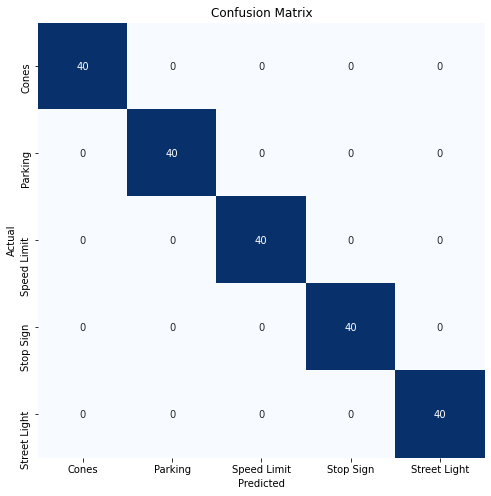

In [16]:
    # Plot the confusion matrix results
    my_ann.plotResults()